In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Pre-processing

In [3]:
 !pip install -qq -U mlxtend

     |████████████████████████████████| 1.3 MB 5.0 MB/s 


In [4]:
import pandas as pd
import numpy
from numpy.random import randint
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.flow import shortest_augmenting_path
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
PORTER_STEMMER = PorterStemmer()

In [6]:
def clean_tweets(x, STOPWORDS):
    # Lowercase
    sentence = x.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub('http[s]?://\S+', '', sentence)
    sentence = re.sub(r'([^a-zA-Z ]+?)', '', sentence)
    #print(sentence)
    #sentence = sentence.replace('\n', '')
    # Remove URLs
    sentence = sentence.replace("world health organization", "who")
    #print(sentence)
    # Remove double spacing
    #sentence = re.sub('\s+', ' ', sentence)
    tokenized_tweet = [word for word in word_tokenize(sentence) if word not in STOPWORDS]
    tokenized_tweet = [PORTER_STEMMER.stem(word) for word in tokenized_tweet]
    return tokenized_tweet

<>:6: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<ipython-input-6-e9114ee358bb>:6: DeprecationWarning: invalid escape sequence \S
  sentence = re.sub('http[s]?://\S+', '', sentence)


In [112]:
pharma_username = ['pfizer']
#'JNJNews', 'AstraZeneca', 'GSK', 'Novartis'
public_username = ['CDCgov', 'IHSgov', 'GovCanHealth', 'GCIndigenous']
ngo_username = ['WHO']

In [55]:

file1 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'CDCgov'+'.csv'
file2 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'IHSgov'+'.csv'
file3 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'GovCanHealth'+'.csv'
file4 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'GCIndigenous'+'.csv'
Sample_Tweets = pd.concat(
map(pd.read_csv, [file1, file2, file3, file4]), ignore_index=True)
print(Sample_Tweets)
# dataFrame.to_csv('/content/drive/MyDrive/Project 2/gephi/public_health_agencies/public_merged.csv')

                        id                 created_at      conversation_id  \
0      1542616744874967040  2022-06-30 21:11:07+00:00  1542616744874967040   
1      1542616268678758400  2022-06-30 21:09:13+00:00  1542616268678758400   
2      1542606417621913607  2022-06-30 20:30:04+00:00  1542606417621913607   
3      1542590047656067073  2022-06-30 19:25:01+00:00  1542590047656067073   
4      1542574696532787200  2022-06-30 18:24:01+00:00  1542574696532787200   
...                    ...                        ...                  ...   
65558  1215291794616999936  2020-01-09 15:18:37+00:00  1215291794616999936   
65559  1214286619458584577  2020-01-06 20:44:25+00:00  1214286619458584577   
65560  1213811169435291648  2020-01-05 13:15:08+00:00  1213811169435291648   
65561  1213086419318644736  2020-01-03 13:15:15+00:00  1213086419318644736   
65562  1212398550774165506  2020-01-01 15:41:54+00:00  1212398550774165506   

                                                   tweet  retwe

In [56]:
Sample_Tweets = Sample_Tweets.sample(n=10)

In [57]:
Sample_Tweets.iloc[0]

id                                                   1483212592265015297
created_at                                     2022-01-17 23:00:13+00:00
conversation_id                                      1483212592265015297
tweet                                            https://t.co/gqunLUAOAR
retweet_count                                                          1
like_count                                                             0
reply_count                                                            0
quote_count                                                            0
expanded_url           https://twitter.com/TheNWHU/status/14820203917...
language                                                             zxx
possibly_sensitive                                                 False
in_reply_to_user_id                                                  NaN
username                                                    GCIndigenous
Name: 62429, dtype: object

In [58]:
stopwords_df = set(nltk.corpus.stopwords.words("english"));
stopwords_df.add("rt")
stopwords_df.add("amp")
print(stopwords_df)

{'such', 'just', 'you', 'whom', 'while', 'between', "hasn't", 'haven', 'should', 'down', 'during', "you're", 'd', 'below', 'against', "you'll", 'do', 'up', 'being', 'our', 'themselves', 'mustn', "mustn't", 'her', 'with', 'above', 'had', 're', 'than', 'him', 'the', 'at', "you'd", 'yourself', 'ma', 'after', 'having', 'or', 'will', 'over', "should've", 'won', 'ain', 'isn', "don't", 'about', 'hadn', "doesn't", "aren't", 'not', "it's", 'when', 'been', 'doesn', 'is', 'itself', 'have', 'has', "shouldn't", 'and', 'mightn', 'no', 'nor', 'their', 'were', 'same', 'shouldn', 'each', 'few', 'on', 'myself', 'by', 'into', 'who', 'can', 'your', 'most', 'out', "you've", 't', "mightn't", 'needn', 'didn', 'don', 'we', 'wouldn', 'its', "haven't", 'all', 'it', 'because', 'i', 'theirs', 'his', 'hers', 'couldn', 'off', "isn't", 'my', 'doing', 'from', 'other', 'rt', 'for', 'further', 'so', 'hasn', 'in', 'they', 'what', 'am', 'these', 'ourselves', 'yourselves', "won't", 'll', 'm', 'then', 'did', 'here', 'ours'

#Word Cloud

In [59]:
df = None
Tweet_Texts=Sample_Tweets['tweet'].values

# Converting the text column as a single string for wordcloud
Tweets_String=str(Tweet_Texts)

# Tweet Text cleaning
import re

# Converting the whole text to lowercase
Tweet_Texts_Cleaned = Tweets_String.lower()

# Removing the twitter usernames from tweet string
Tweet_Texts_Cleaned=re.sub(r'@\w+', ' ', Tweet_Texts_Cleaned)

# Removing the URLS from the tweet string
Tweet_Texts_Cleaned=re.sub(r'http\S+', ' ', Tweet_Texts_Cleaned)


# Deleting everything which is not characters
Tweet_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',Tweet_Texts_Cleaned)

# Deleting any word which is less than 3-characters mostly those are stopwords
Tweet_Texts_Cleaned= re.sub(r'\b\w{1,2}\b', '', Tweet_Texts_Cleaned)

# Stripping extra spaces in the text
Tweet_Texts_Cleaned= re.sub(r' +', ' ', Tweet_Texts_Cleaned)

Tweet_Texts_Cleaned
# for username in pharma_username:

  # Sample_Tweets = pd.read_csv('/content/drive/MyDrive/Project 2/data/pharma_companies/'+username+'.csv')

  #only 10 rows
  # Sample_Tweets = Sample_Tweets[:10]
  
  #clean tweets
  # Extracting only the Tweet text from the data frame
  # Tweet_Texts=Sample_Tweets['tweet'].values

  # # Converting the text column as a single string for wordcloud
  # Tweets_String=str(Tweet_Texts)

  # # Tweet Text cleaning
  # import re

  # # Converting the whole text to lowercase
  # Tweet_Texts_Cleaned = Tweets_String.lower()

  # # Removing the twitter usernames from tweet string
  # Tweet_Texts_Cleaned=re.sub(r'@\w+', ' ', Tweet_Texts_Cleaned)

  # # Removing the URLS from the tweet string
  # Tweet_Texts_Cleaned=re.sub(r'http\S+', ' ', Tweet_Texts_Cleaned)


  # # Deleting everything which is not characters
  # Tweet_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',Tweet_Texts_Cleaned)

  # # Deleting any word which is less than 3-characters mostly those are stopwords
  # Tweet_Texts_Cleaned= re.sub(r'\b\w{1,2}\b', '', Tweet_Texts_Cleaned)

  # # Stripping extra spaces in the text
  # Tweet_Texts_Cleaned= re.sub(r' +', ' ', Tweet_Texts_Cleaned)

  # Tweet_Texts_Cleaned

' adverse events following immunization are routinely monitored and information adverse events following immunization with covid vaccines including breakdowns reports vaccine name age and sex are published health canada proud work amp kilala lelum health centre improve health outcomes and access services for people risk overdose british columbia understandable that many people may feel distress anxiety during the covid pandemic joshua gordon director nice you all set receive weekly information the covid vaccines reply stop unsubscribe you will receive mental health tips and resources every friday est for the next weeks nreply stop opt out even pandemic nothing brings people together like food whether you beginner self proclaimed masterchef enrolling online cooking class with friends can help you all taste something new nreply unsubscribe opt out for more information how canada identifies groups for early vaccination the ihs navajo area continues work with tribal state amp local partner

In [14]:
print(Tweet_Texts_Cleaned)

 the government has introduced series measures support canadians during the covid pandemic and some these you can help protect people who are more likely get severely ill from covid getting vaccinated soon you can are still learning how well covid vaccines protect people with weakened immune systems nlearn more with all vaccines health canada will continue monitor the safety and efficacy these vaccines once they are the market and will not hesitate take action any safety concerns are identified firstnations living off reserve inuit and tis can receive the covid vaccine through provincial territorial health services local indigenous healthcare organizations nrhd twitter chat starting follow our twitter chat examining social determinants health rural here are some resources activities and opportunities help you take care yourself and your family and support your well being together nreply stop opt out going bar limit alcohol stick your trusted consistent social circle and don share vapes

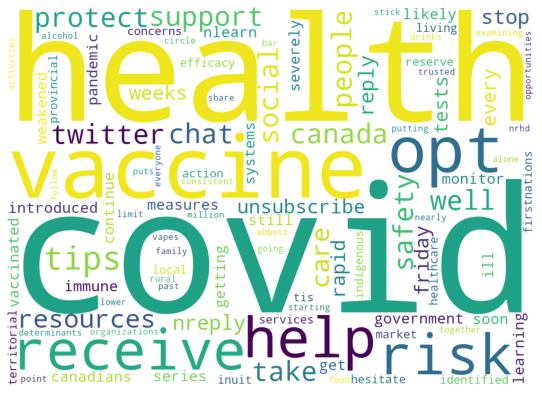

In [15]:
# Plotting the wordcloud 
# you can specify fonts, stopwords, background color and other options
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Creating the custom stopwords
customStopwords=list(stopwords_df)

wordcloudimage = WordCloud(
                          max_words=100,
                          max_font_size=500,
                          font_step=2,
                          stopwords=customStopwords,
                          background_color='white',
                          width=1000,
                          height=720
                          ).generate(Tweet_Texts_Cleaned)

plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

#ARM (Itemsets)

In [16]:
from google.colab import output
output.enable_custom_widget_manager()

In [60]:
df = Sample_Tweets
  
#clean tweets
tqdm.pandas()
df["tokenized_tweet"] = df["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))
tokenized_tweets = df["tokenized_tweet"].values.tolist()
te = TransactionEncoder()
te_ary = te.fit(tokenized_tweets).transform(tokenized_tweets)
df = pd.DataFrame(te_ary, columns=te.columns_)

#Itemsets


min_sup=0.5
frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
print("len of frequent itemsets: ", len(frequent_itemsets.index))

while(len(frequent_itemsets.index)<100):
  min_sup = min_sup/2
  frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
  print("len of frequent itemsets: ", len(frequent_itemsets.index))

itemsets_df = frequent_itemsets[:100] 
print(itemsets_df)
itemsets_df.to_csv("itemsets.csv");
# for username in pharma_username:

  # df = pd.read_csv('/content/drive/MyDrive/Project 2/data/pharma_companies/'+username+'.csv')
  
  #only 10 rows
  # df = df[:10]
  # df = Sample_Tweets

  # #clean tweets
  # tqdm.pandas()
  # df["tokenized_tweet"] = df["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))
  # tokenized_tweets = df["tokenized_tweet"].values.tolist()
  # te = TransactionEncoder()
  # te_ary = te.fit(tokenized_tweets).transform(tokenized_tweets)
  # df = pd.DataFrame(te_ary, columns=te.columns_)

  # #Itemsets
  
  
  # min_sup=0.5
  # frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
  # print("len of frequent itemsets: ", len(frequent_itemsets.index))

  # while(len(frequent_itemsets.index)<100):
  #   min_sup = min_sup/2
  #   frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
  #   print("len of frequent itemsets: ", len(frequent_itemsets.index))

  # itemsets_df = frequent_itemsets[:100] 
  # print(itemsets_df)
  # itemsets_df.to_csv("itemsets.csv");

  

KeyboardInterrupt: ignored

In [ ]:

allItems = []
for i in itemsets_df['itemsets']:
    for j in i:
        allItems.append(j)
        
bar_df = pd.DataFrame(allItems, columns=['Items'])
print(bar_df['Items'].value_counts().head(10))
bar_df['Items'].value_counts().head(10).plot.bar()

In [61]:
df

ac  access  adequ  advers    age     al  anxieti   area  avivanisl  \
0  False   False  False   False  False  False    False  False      False   
1  False   False  False    True   True  False    False  False      False   
2  False    True  False   False  False  False    False  False       True   
3  False   False  False   False  False  False     True  False      False   
4  False   False  False   False  False  False    False  False      False   
5  False   False  False   False  False  False    False  False      False   
6  False   False  False   False  False  False    False  False      False   
7  False   False  False   False  False  False    False  False      False   
8   True   False   True   False  False  False    False   True      False   
9  False   False  False   False  False   True    False  False      False   

   bccfe  ...  vaccin  vchhealthcar  visit      w   want   week  weekli  \
0  False  ...   False         False  False  False  False  False   False   
1  False  ...    True         False  False  False  False  False   False   
2   True  ...   False          True  False   True  False  False   False   
3  False  ...   False         False  False  False  False  False   False   
4  False  ...    True         False  False  False  False  False    True   
5  False  ...   False         False  False  False  False   True   False   
6  False  ...   False         False  False  False  False  False   False   
7  False  ...    True         False  False  False  False  False   False   
8  False  ...   False         False  False  False  False  False   False   
9  False  ...   False         False   True  False   True  False   False   

   whether   work   your  
0    False  False  False  
1    False  False  False  
2    False   True  False  
3    False  False  False  
4    False  False   True  
5    False  False  False  
6     True  False   True  
7    False  False  False  
8    False   True  False  
9    False  False  False  

[10 rows x 131 columns]

    Confidence  Number of rules
0          0.0               28
1          0.1               28
2          0.2               28
3          0.3               28
4          0.4               28
5          0.5               28
6          0.6               25
7          0.7               19
8          0.8               19
9          0.9               19
10         1.0               19


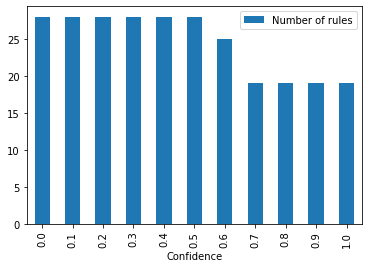

In [64]:
frequent_itemsets2 = apriori(df, min_support=0.2, use_colnames=True)
frequent_itemsets2

confidence = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
number_of_rules = []

for i in confidence:
    a = association_rules(frequent_itemsets2, metric="confidence", min_threshold=i)
    number_of_rules.append(len(a))

data = {'Confidence': confidence, 'Number of rules': number_of_rules}
df2 = pd.DataFrame(data=data)
print(df2)
plot = df2.plot.bar(x='Confidence', y='Number of rules')

In [ ]:
association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.6)


#ARM (Rules)

In [ ]:
matrix_df = pd.DataFrame(columns=['Threshold Support', 'Threshold Confidence', 'Count of rules'])
for min_support_initialize in np.arange(0.001, 0.5, 0.5):
  for min_threshold_initialize in np.arange(0.5, 0.6, 0.1):
    frequent_itemsets_temp = apriori(df, min_support=min_support_initialize, use_colnames=True)

    rules = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=min_threshold_initialize)
  # rules = rules.sort_values(by='confidence', ascending =False)
  # print(rules)
    matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
  
print(matrix_df)

In [ ]:
from IPython.core.pylabtools import figsize
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

# defining all 3 axes
z = matrix_df['Count of rules']
x = matrix_df['Threshold Confidence']
y = matrix_df['Threshold Support']

# plotting
ax.scatter(x, y, z)
ax.set_title('Min confidence vs Min support')
ax.set_xlabel('Min confidence')
ax.set_ylabel('Min support')
ax.set_zlabel('Count of rules')
plt.show()


In [65]:
# 10               0.25                   0.0             4.0
frequent_itemsets_temp = apriori(df, min_support=0.2, use_colnames=True)

rules = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=1)
rules[rules['lift']>=1]
print(rules)

        antecedents      consequents  antecedent support  consequent support  \
0          (inform)         (vaccin)                 0.3                 0.3   
1          (vaccin)         (inform)                 0.3                 0.3   
2          (pandem)          (peopl)                 0.2                 0.3   
3           (repli)         (receiv)                 0.2                 0.2   
4          (receiv)          (repli)                 0.2                 0.2   
5            (stop)         (receiv)                 0.2                 0.2   
6          (receiv)           (stop)                 0.2                 0.2   
7            (stop)          (repli)                 0.2                 0.2   
8           (repli)           (stop)                 0.2                 0.2   
9      (unsubscrib)           (your)                 0.2                 0.2   
10           (your)     (unsubscrib)                 0.2                 0.2   
11  (inform, covid)         (vaccin)    

In [75]:
type(rules)

pandas.core.frame.DataFrame

In [76]:
df1 = (rules.explode('antecedents')
         .reset_index(drop=True)
         .explode('consequents')
         .reset_index(drop=True))
df1.to_csv('rules.csv')

#Bokeh plot

In [77]:
import pandas as pd
import networkx
import matplotlib.pyplot as plt
import numpy as np

In [78]:
!pip install bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
from bokeh.io import output_notebook, show, save

In [80]:
got_df = pd.read_csv('/content/rules.csv')

In [81]:
G = networkx.from_pandas_edgelist(got_df, 'antecedents', 'consequents')

In [82]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

In [83]:
#Choose a title!
title = 'Bokeh plot'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Character", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)


In [84]:
save(plot, filename=f"{title}.html")

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/content/Bokeh plot.html'

#Followers (Maybe not)

In [85]:
# !pip install -U -qq tweepy

In [86]:
import tweepy

In [87]:
# Initialize bearer token and client
bearer_token = "AAAAAAAAAAAAAAAAAAAAAD2hVAEAAAAAjBhkrfvf%2BEftzMPhDJt1oXHLCh4%3D0J5mIvBgW81rnqoNcUXOFMOCqv83ANsZZoELvCvxAYiYnUm4Ql"
client = tweepy.Client(bearer_token=bearer_token)

AttributeError: ignored

In [ ]:
def getUserInfo(client,username):
    user = client.get_user(username=username,user_fields='public_metrics')
    return user


d =getUserInfo(client,'pfizer')

d.data.public_metrics['followers_count']

In [ ]:
client.get_users_followers(id=56488059, max_results=100)

In [ ]:
def getTargetFollowers(n=100, m=150):
  screen_name = 'JoeBiden'
  target_followers = list()
  n = m
  f = tweepy.Cursor(api.get_followers(), screen_name).items(n)
  for fol in f:
    if not fol.protected:
      target_followers.append(fol.screen_name)
    if len(target_followers) == n:
      break
  print(len(target_followers))
  dff = pd.DataFrame(columns=target_followers)
  print(dff.shape)
  return(dff)

#Metrics
Recommender systems can also profit from the messages shared on social media 

The higher the engagement of a tweet, the more likely it is to contain popular association rule.




In [66]:
Sample_Tweets['Tweet_rank'] = Sample_Tweets['like_count']+Sample_Tweets['quote_count']+Sample_Tweets['reply_count']+Sample_Tweets['retweet_count']

In [69]:
Sample_Tweets = Sample_Tweets.sort_values(by=['Tweet_rank'], ascending=False)


In [70]:
Sample_Tweets["tokenized_tweet"] = Sample_Tweets["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))


  0%|          | 0/10 [00:00<?, ?it/s]

In [71]:
Sample_Tweets

id                 created_at      conversation_id  \
5830   1286043389289529344  2020-07-22 21:00:12+00:00  1286043389289529344   
7206   1227303297138163714  2020-02-11 18:48:02+00:00  1227303297138163714   
9027   1252727419825512455  2020-04-21 22:34:26+00:00  1252727419825512455   
47700  1356633863854977027  2021-02-02 16:01:32+00:00  1356633863854977027   
33150  1413589482322935811  2021-07-09 20:02:50+00:00  1413589482322935811   
62429  1483212592265015297  2022-01-17 23:00:13+00:00  1483212592265015297   
22996  1487092795735252996  2022-01-28 15:58:46+00:00  1481717694969749505   
42286  1408122764741861378  2021-06-24 18:00:03+00:00  1408122764741861378   
17410  1493092466064609280  2022-02-14 05:19:18+00:00  1493092466064609280   
47344  1362802211055689728  2021-02-19 16:32:21+00:00  1361710688603897859   

                                                   tweet  retweet_count  \
5830   RT @HHSGov: It’s understandable that many peop...            141   
7206   Are you living with #ALS? Do you want to make ...             19   
9027   The IHS Navajo Area continues to work with tri...              9   
47700  Health Canada is proud to work w/ @AVIVanIsle ...              2   
33150  @o_livelaughlove Even in a pandemic, nothing b...              0   
62429                            https://t.co/gqunLUAOAR              1   
22996  @90iqdegen (3/5) Adverse events following immu...              0   
42286  @saanich Nice! You’re all set to receive weekl...              0   
17410  @HENROBY1 you will receive mental health tips ...              0   
47344  @JenniferRose For more information on how Cana...              0   

       like_count  reply_count  quote_count  \
5830            0            0            0   
7206           20            1            2   
9027           12            0            0   
47700           6            3            1   
33150           1            1            0   
62429           0            0            0   
22996           0            1            0   
42286           0            0            0   
17410           0            0            0   
47344           0            0            0   

                                            expanded_url language  \
5830                                                 NaN       en   
7206                              https://bit.ly/3aBL0C2       en   
9027   https://www.cnn.com/videos/us/2020/04/17/navaj...       en   
47700                           http://ow.ly/cdOE50DobMl       en   
33150                                                NaN       en   
62429  https://twitter.com/TheNWHU/status/14820203917...      zxx   
22996                                                NaN       en   
42286  https://twitter.com/GovCanHealth/status/140812...       en   
17410  https://twitter.com/GovCanHealth/status/149309...       en   
47344  https://www.canada.ca/en/public-health/service...       en   

       possibly_sensitive  in_reply_to_user_id      username  \
5830                False                  NaN        CDCgov   
7206                False                  NaN        CDCgov   
9027                False                  NaN        IHSgov   
47700               False                  NaN  GovCanHealth   
33150               False         1.344120e+18  GovCanHealth   
62429               False                  NaN  GCIndigenous   
22996               False         3.637582e+07  GovCanHealth   
42286               False         1.392317e+08  GovCanHealth   
17410               False         1.133474e+18  GovCanHealth   
47344               False         3.637582e+07  GovCanHealth   

                                         tokenized_tweet  Tweet_rank  
5830   [hhsgov, understand, mani, peopl, may, feel, d...         141  
7206   [live, al, want, make, differ, futur, gener, t...          42  
9027   [ih, navajo, area, continu, work, tribal, stat...          21  
47700  [health, canada, proud, work, w, avivanisl, pr...          12  
3

In [72]:
Sample_Tweets["tokenized_tweet"]

5830     [hhsgov, understand, mani, peopl, may, feel, d...
7206     [live, al, want, make, differ, futur, gener, t...
9027     [ih, navajo, area, continu, work, tribal, stat...
47700    [health, canada, proud, work, w, avivanisl, pr...
33150    [olivelaughlov, even, pandem, noth, bring, peo...
62429                                                   []
22996    [iqdegen, advers, event, follow, immun, routin...
42286    [saanich, nice, your, set, receiv, weekli, inf...
17410    [henrobi, receiv, mental, health, tip, resourc...
47344    [jenniferros, inform, canada, identifi, group,...
Name: tokenized_tweet, dtype: object

In [94]:
type(Sample_Tweets['tokenized_tweet'])

pandas.core.series.Series

In [73]:
sorted_df = Sample_Tweets['tokenized_tweet']

In [96]:
sorted_df.to_csv('sorted.csv')

In [50]:
Sample_Tweets.iloc[5]['tweet']

'@OhhhJackieBaby1 you will receive mental health tips and resources every Friday @ 4pm EST for the next 4 weeks. \nReply #stop to opt-out. https://t.co/4BhlvsGHy7'

In [74]:
rules['rank'] = rules['antecedent support']+rules['confidence']+rules['consequent support']+rules['leverage']+rules['lift']+rules['support']

In [75]:
sorted_rules = rules.sort_values(by=['rank'], ascending=False)

In [76]:
sorted_rules

antecedents      consequents  antecedent support  consequent support  \
9      (unsubscrib)           (your)                 0.2                 0.2   
8           (repli)           (stop)                 0.2                 0.2   
17          (repli)   (stop, receiv)                 0.2                 0.2   
16           (stop)  (repli, receiv)                 0.2                 0.2   
15  (repli, receiv)           (stop)                 0.2                 0.2   
14   (stop, receiv)          (repli)                 0.2                 0.2   
13    (stop, repli)         (receiv)                 0.2                 0.2   
10           (your)     (unsubscrib)                 0.2                 0.2   
18         (receiv)    (stop, repli)                 0.2                 0.2   
7            (stop)          (repli)                 0.2                 0.2   
6          (receiv)           (stop)                 0.2                 0.2   
5            (stop)         (receiv)                 0.2                 0.2   
4          (receiv)          (repli)                 0.2                 0.2   
3           (repli)         (receiv)                 0.2                 0.2   
1          (vaccin)         (inform)                 0.3                 0.3   
0          (inform)         (vaccin)                 0.3                 0.3   
11  (inform, covid)         (vaccin)                 0.2                 0.3   
12  (covid, vaccin)         (inform)                 0.2                 0.3   
2          (pandem)          (peopl)                 0.2                 0.3   

    support  confidence      lift  leverage  conviction      rank  
9       0.2         1.0  5.000000      0.16         inf  6.760000  
8       0.2         1.0  5.000000      0.16         inf  6.760000  
17      0.2         1.0  5.000000      0.16         inf  6.760000  
16      0.2         1.0  5.000000      0.16         inf  6.760000  
15      0.2         1.0  5.000000      0.16         inf  6.760000  
14      0.2         1.0  5.000000      0.16         inf  6.760000  
13      0.2         1.0  5.000000      0.16         inf  6.760000  
10      0.2         1.0  5.000000      0.16         inf  6.760000  
18      0.2         1.0  5.000000      0.16         inf  6.760000  
7       0.2         1.0  5.000000      0.16         inf  6.760000  
6       0.2         1.0  5.000000      0.16         inf  6.760000  
5       0.2         1.0  5.000000      0.16         inf  6.760000  
4       0.2         1.0  5.000000      0.16         inf  6.760000  
3       0.2         1.0  5.000000      0.16         inf  6.760000  
1       0.3         1.0  3.333333      0.21         inf  5.443333  
0       0.3         1.0  3.333333      0.21         inf  5.443333  
11      0.2         1.0  3.333333      0.14         inf  5.173333  
12      0.2         1.0  3.333333      0.14         inf  5.173333  
2       0.2         1.0  3.333333      0.14         inf  5.173333

In [101]:
type(sorted_rules['antecedents'])

pandas.core.series.Series

#Accuracy

Compare sorted_rules['antecedents']+sorted_rules['consequents]' with Sample_tweets['tokenized_tweet'] using iloc

In [102]:
type(list(sorted_rules.iloc[0]['antecedents']))

list

In [103]:
count=0
l1 = list(sorted_rules.iloc[0]['antecedents'])
for value in l1:
  if value in sorted_df.iloc[0]:
    count=count+1
l2 = list(sorted_rules.iloc[0]['consequents'])
if(count==len(l1)):
  for value in l2:
    if value in sorted_df.iloc[0]:
      count=count+1
if(count==len(l1)+len(l2)):
  print("exists")
else:
  print("does not exist")

exists


In [77]:
len(sorted_rules.index)

19

In [78]:
len(sorted_df.index)

10

In [79]:
counter=0

save_df = pd.DataFrame(columns=['Tweet ID', 'Rule No.', 'Exists'])
# matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
for i in range (0, 10, 1):
  for j in range(0, 19, 1):
    count=0
    l1 = list(sorted_rules.iloc[j]['antecedents'])
    for value in l1:
      if value in sorted_df.iloc[i]:
        count=count+1
    l2 = list(sorted_rules.iloc[j]['consequents'])
    if(count==len(l1)):
      for value in l2:
        if value in sorted_df.iloc[i]:
          count=count+1
    if(count==len(l1)+len(l2)):
      save_df[len(save_df.index)] = [i, j, 1]
      print("Tweet ", i, " contains rule number ", j)
      counter=counter+1 
# for i in range(0, 5, 1):
#   for j in range(0, 75798, 1):
#     count=0
#     l1 = list(sorted_rules.iloc[j]['antecedents'])
#     for value in l1:
#       if value in sorted_df.iloc[i]:
#         count=count+1
#     l2 = list(sorted_rules.iloc[j]['consequents'])
#     if(count==len(l1)):
#       for value in l2:
#         if value in sorted_df.iloc[i]:
#           count=count+1
#     if(count==len(l1)+len(l2)):
#       print(j, " exists at ", i)
#       counter=counter+1
#     else:
#       print("does not exist")

Tweet  0  contains rule number  18
Tweet  4  contains rule number  0
Tweet  4  contains rule number  7
Tweet  4  contains rule number  18
Tweet  6  contains rule number  14
Tweet  6  contains rule number  15
Tweet  6  contains rule number  16
Tweet  6  contains rule number  17
Tweet  7  contains rule number  0
Tweet  7  contains rule number  1
Tweet  7  contains rule number  2
Tweet  7  contains rule number  3
Tweet  7  contains rule number  4
Tweet  7  contains rule number  5
Tweet  7  contains rule number  6
Tweet  7  contains rule number  7
Tweet  7  contains rule number  8
Tweet  7  contains rule number  9
Tweet  7  contains rule number  10
Tweet  7  contains rule number  11
Tweet  7  contains rule number  12
Tweet  7  contains rule number  13
Tweet  7  contains rule number  14
Tweet  7  contains rule number  15
Tweet  7  contains rule number  16
Tweet  7  contains rule number  17
Tweet  8  contains rule number  1
Tweet  8  contains rule number  2
Tweet  8  contains rule number  3


In [39]:
counter

0